# EE301A Assignment 2
- Use python3
- Submit your "rendered" ipynb, i.e., with outputs of codes (plots and printed values) visible below
- DO NOT CHANGE the codes anywhere, except where you are asked to write. Otherwise automatic evaluation will fail.
- Use only numpy library for computing and signal processing. No package allowed other than those imported below.

In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
np.random.seed(35)

## Q1: Audio Filtering
A signal can be filtered using convolution. But if it is a streaming signal (non-zero for $t\geq 0$), then we need to filter it buffer by buffer. This exercise will take you through one way of doing it. 

In [2]:
def readAudio(in_filename):
    '''
    in_filename: path to the input wav file (str)
    xn: waveform, take the first channel if it has two channels (np.array 1D)
    Fs: sampling rate (int)
    '''
    x,Fs = sf.read(in_filename)
    xn=x[:,0]
    ### WRITE YOUR CODE HERE - 2 MARKS

    return xn, Fs
# readAudio('ass2_flute.wav')

In [3]:
def addNoise(xn, mu, sigma):
    '''
    xn: (np.array 1D)
    mu: mean of Gaussian noise (float)
    sigma: std dev of Gaussian noise (float)
    yn: (np.array 1D)
    '''
    n = len(xn)
    yn = xn + np.random.normal(mu,sigma,n)
    
    ### WRITE YOUR CODE HERE - 2 MARKS

    return yn

In [4]:
def filtering(xn, hn):
    '''
    xn: (np.array 1D)
    hn: (np.array 1D)
    yn: (np.array 1D)
    '''
    yn = np.convolve(xn,hn)
    ### WRITE YOUR CODE HERE - 2 MARKS

    return yn

In [5]:
def writeAudio(xn, Fs, out_filename):
    '''
    xn: (np.array 1D)
    Fs: sampling rate (int)
    out_filename: path to the output wav file (str)
    '''
    sf.write(out_filename,xn,Fs)

    ### WRITE YOUR CODE HERE - 2 MARKS

    return

In [6]:
def getSTFT(xn, win, hop, Ndft):
    '''
    Write yourself. Do not use any library other than numpy.
    xn: (np.array 1D)
    win: window length in samples (int)
    hop: hop size in samples (int)
    Ndft: N for DFT (int)
    X_km: STFT of xn; k is freq index, m is window index (np.array 2D)
    '''
    n = len(xn)
    n_w = int(np.ceil(n/hop))
    X_km = np.zeros((Ndft,n_w),dtype=complex)
    window = np.hanning(win)    #I'm using a hann window here
    add = np.zeros(win)
    additional = np.zeros(Ndft-win)
    xn1 = np.append(xn,win) #zero padding xn with length of one window
    for i in range(n_w):
        seg = np.copy(xn1[i*hop:i*hop+win])
#         seg = seg * window
#         seg = np.append(se,additional)
        row = np.fft.fft(seg,n=Ndft)
        X_km[:,i] = row
    ### WRITE YOUR CODE HERE - 6 MARKS

    return X_km

If xn is streaming, it is wise to take chunks (buffers) and filter them using overlap add method. Use product of DFT{hn} and X_km to get the convolution for each m. Hint: the output of filteringOverlapAdd(getSTFT(xn, ...), hn) should match the output of filtering(xn, hn).

In [7]:
def filteringOverlapAdd(X_km, hn, win, hop, Ndft):
    '''
    X_km: STFT of xn (np.array 2D)
    hn: (np.array 1D)
    win: window length in samples (int). You may need this for OverlapAdd
    hop: hop size in samples (int). You may need this for OverlapAdd
    Ndft: N for DFT (int). You may need this for OverlapAdd
    yn: (np.array 1D)
    '''
    n_w = X_km.shape[1]
#     print(n_w)
    padding = np.zeros(Ndft-win)
    DFT = np.fft.fft(hn,n=Ndft)
    
    y = np.zeros(Ndft-win+win*n_w,dtype = complex)
    for i in range(n_w):
        u = np.fft.ifft(X_km[:,i]*DFT,n=Ndft)
        y[i*win:(i*win+len(u))] = u + y[i*win:(i*win+len(u))]
    yn = y
    ### WRITE YOUR CODE HERE - 15 MARKS

    return yn

#### Experiment
1. Read ass2_flute.wav file. Plot the clean signal between 1s to 1.01s.
2. Add noise of 0 mean and 0.05 std. dev., and save it as ass2_flute_noisy.wav. Plot the noisy signal between 1s to 1.01s.
3. Filter it using filtering() with a moving average filter of length 20, and save it as ass2_flute_filtered.wav. Plot the filtered signal between 1s to 1.01s.
4. Filter it using filteringOverlapAdd() with a moving average filter of length 20, and save it as ass2_flute_filteredOLA.wav. Plot the filtered signal between 1s to 1.01s.

Sample plots are shown

C:\Users\akhil\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


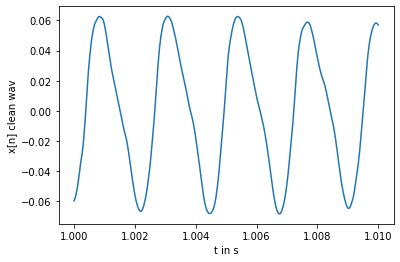

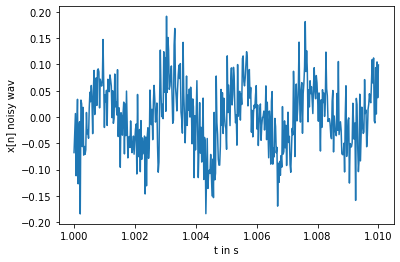

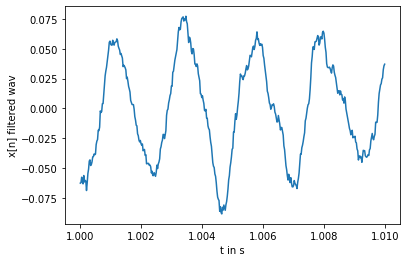

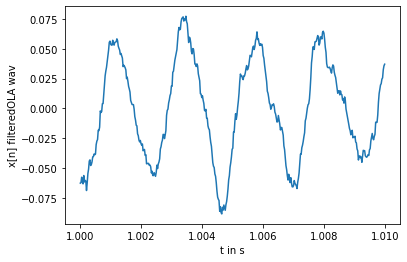

In [8]:

def experiment1():
    mu = 0
    sigma = 0.05
    xn,Fs = readAudio("ass2_flute.wav")
#     print(len(xn))
    t = np.arange(1,1.01,1/Fs)
    n1 = int(Fs)
    n2 = int(Fs*1.01)+1
    x = (xn[n1:n2])
    f1 = plt.figure()
    plt.plot(t,x)
    plt.xlabel("t in s")
    plt.ylabel("x[n] clean wav")
    yn = addNoise(xn,mu,sigma)
    tn = yn
    x = yn[n1:n2]
    f2 = plt.figure()
    plt.plot(t,x)
    plt.xlabel("t in s")
    plt.ylabel("x[n] noisy wav")
    
    hn = np.ones(20)
    hn = hn/20
    yn = filtering(tn,hn)
    writeAudio(yn,Fs,"ass2_flute_filtered.wav")
    x = yn[n1:n2]
    f3 = plt.figure()
    plt.plot(t,x)
    plt.xlabel("t in s")
    plt.ylabel("x[n] filtered wav")
    X_km = getSTFT(tn,20,20,40) 
    #I'm taking a window size of 20 and thus a hop size of 20 and Ndft = 40 > 39
    
#     print(X_km)
    yn = filteringOverlapAdd(X_km,hn,20,20,40)
    un = np.real(yn)
    writeAudio(un,Fs,"ass2_flute_filteredOLA.wav")
    x = yn[n1:n2]
    f4 = plt.figure()
    plt.plot(t,x)
    plt.xlabel("t in s")
    plt.ylabel("x[n] filteredOLA wav")
    plt.show()
    ### WRITE YOUR CODE HERE - 8 MARKS


if __name__=="__main__":
    experiment1()

## Q2. Real signal analysis
In real world, we measure different signals, and we need to see if they have some strong frequency components. E.g., I told you the story of 50Hz noise in the audio transmission during convocation at IITK Auditorium around 2010-11. This exercise will take you through one such scenario.

Given $x(t)=\sin(2\pi f_1 t)+\sin(2\pi f_2 t)$. Generate the signal and plot its spectrum (frequency in Hz at x-axis) that shows peaks at frequencies $f_1$ and $f_2$. Choose the range of x-axis appropriately so that you can clearly see if the peaks are indeed at $f_1$ and $f_2$.

(Choose Fs appropriately, choose Ndft appropriately, mark the axes appropriately. You may need to plot y-axis on log scale to see the entire dynamic range distinctly.)

In [9]:
def plotSpectrum(f1, f2):
    '''
    f1: (float)
    f2: (float)
    '''
    Fs =500
    Ndft = Fs
    x1 = np.arange(0,1,1/Fs) #Time is taken upto 1 second
    yn = np.sin(2*np.pi*x1*f1)+np.sin(2*np.pi*x1*f2)
    Y = np.fft.fft(yn,n=Ndft)
    Mod1 = 20*np.log10(np.abs(Y*np.conj(Y)))
    f = np.ones(len(Y))
    for i in range(len(f)):
        f[i] = i*Fs/Ndft
    f1 = plt.figure()
    Mod = np.abs(Y*np.conj(Y))
    plt.plot(f[:60],Mod1[:60])
    plt.ylabel("DFT Modulus")
    plt.xlabel("Frquency(Hz)")
    ### WRITE YOUR CODE HERE - 3 MARKS

    return
# plotSpectrum(20, 50)

Given $x(t)=\sin(2\pi f_1 t)+\sin(2\pi f_2 t)$. Generate the signal and plot its spectrogram (frequency in Hz at y-axis, time in s at x-axis) that shows peaks at frequencies $f_1$ and $f_2$. Choose the range of y-axis appropriately so that you can clearly see if the peaks are indeed at $f_1$ and $f_2$.

In [10]:
def plotSpectrogram(f1, f2):
    '''
    f1: (float)
    f2: (float)
    '''
    Fs =500
    Ndft = Fs
    x1 = np.arange(0,1,1/Fs) #Time is taken upto 1 second
    yn = np.sin(2*np.pi*x1*f1)+np.sin(2*np.pi*x1*f2)
    X_mk = getSTFT(yn,100,1,Ndft)
    X_mk = np.abs(X_mk*np.conj(X_mk))
    f = np.ones(Ndft)
    for i in range(len(f)):
        f[i] = i*Fs/Ndft
    f1 = plt.figure()
    plt.pcolormesh(x1[:300],f[:100],X_mk[:100,:300])
    plt.xlabel("t in sec")
    plt.ylabel('F in Hz')
    ### WRITE YOUR CODE HERE - 5 MARKS

    return
# plotSpectrogram(20, 50)

Given an audio file, plot its spectrogram (frequency in Hz at y-axis, time in s at x-axis). Visible frequency limits should be adjustable to see a part of spectra.

In [11]:
def plotAudioSpectrogram(filename_in, f_min, f_max):
    '''
    in_filename: path to the input wav file (str)
    f_min: minimum frequency value in Hz visible on y-axis (float)
    f_max: maximum frequency value in Hz visible on y-axis (float)
    '''
    x,Fs = sf.read(filename_in)
    xn=x[:,0]
    win = 1000
    Ndft = int(Fs/5)
    hop = 100
    t = np.arange(0,len(xn)/Fs,hop/Fs)
    f = np.ones(Ndft)
    for i in range(len(f)):
        f[i] = i*Fs/Ndft
    X_mk = getSTFT(xn,win,hop,Ndft)
    X_mk = np.abs(X_mk)
    f1 = plt.figure()
    plt.pcolormesh(t,f[int(f_min*Ndft/Fs):int(f_max*Ndft/Fs)],X_mk[int(f_min*Ndft/Fs):int(f_max*Ndft/Fs),:])
    plt.xlabel("t in sec")
    plt.ylabel('F in Hz')
#     print(Fs)
#     print(int(f_min*Ndft/Fs))
#     print(int(f_max*Ndft/Fs))
    ### WRITE YOUR CODE HERE - 5 MARKS
    
    return 

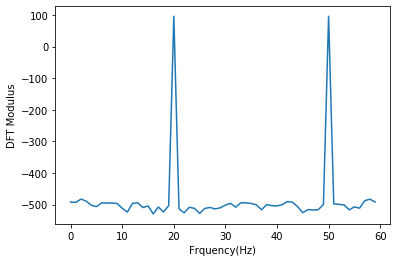

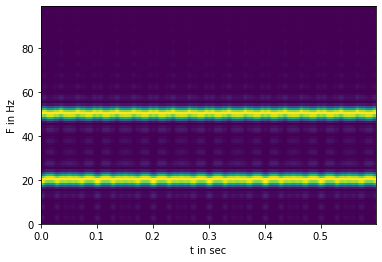

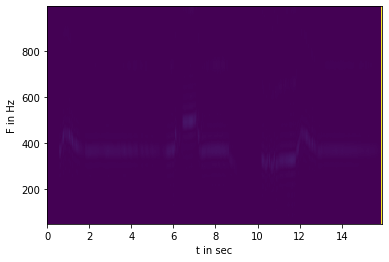

In [12]:
if __name__=="__main__":
    plotSpectrum(20, 50)
    plotSpectrogram(20, 50)
    plotAudioSpectrogram('ass2_flute.wav', 50., 1000.)

## Q3. Filter Design


Given a z-transform
$H(z)=Az^c \frac{\prod_i(z-a_i)}{\prod_i(z-b_i)}$
1. plotHz(): Plot the poles and zeros in the z-plane
2. plotHejw(): Plot the magnitude and phase spectra of $H(e^{j\omega})$ for $\omega\in(-\pi,\pi)$.

Sample plots are shown

In [13]:
def plotHz(A, c=0, ai=[], bi=[]):
    '''
    c: (int)
    ai: zeros (list of floats)
    bi: poles (list of floats)
    '''
    ai = np.array(ai)
    bi = np.array(bi)
    aireal = []
    aiim = []
    bireal = []
    biim = []
    while(c>0):
        aireal.append(0)
        aiim.append(0)  
        c = c-1
    while(c<0):
        bireal.append(0)
        biim.append(0)
    for i in range(len(ai)):
        aireal.append(np.real(ai[i]))
        aiim.append(np.imag(ai[i]))
    for i in range(len(bi)):
        bireal.append(np.real(bi[i]))
        biim.append(np.imag(bi[i]))
#     print(aireal)
    fig, ax = plt.subplots()
    ax.scatter(aireal,aiim,marker='o')
    ax.scatter(bireal,biim,marker='x')
    ### WRITE YOUR CODE HERE - 5 MARKS
    plt.grid()
    cir = plt.Circle((0,0),1,color = 'blue',fill = False)
    
    ax.add_artist(cir)
    plt.axis('equal')
    plt.xlabel('Re{z}')
    plt.ylabel('Im{z}')
    plt.show()
    return

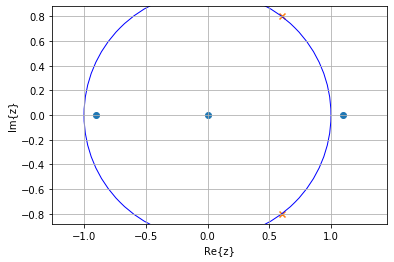

In [14]:
if __name__=="__main__":
    plotHz(1+2j, 1, [-0.9, 1.1], [0.6+0.8j, 0.6-0.8j])

In [79]:
def plotHejw(A, c=0, ai=[], bi=[]):
    '''
    c: (int)
    ai: zeros (list of floats)
    bi: poles (list of floats)
    '''
    ai = np.array(ai)
    bi = np.array(bi)
    w = np.arange(-1*np.pi,np.pi,0.01)
    Mod = np.ones(len(w),dtype=complex)
    for i in range(len(ai)):
        for j in range(len(w)):
            Mod[j] = Mod[j] *(np.exp(complex(0,1)*w[j])-ai[i])
#             Phase[j] = Phase[j] + np.angle(np.exp(complex(0,1)*w[j])-ai[i],deg=False)
    ### WRITE YOUR CODE HERE - 5 MARKS
    
    for i in range(len(bi)):
        for j in range(len(w)):
            Mod[j] = Mod[j] /(np.exp(complex(0,1)*w[j])-bi[i])
#             Phase[j] = Phase[j] - np.angle(np.exp(complex(0,1)*w[j])-bi[i],deg = False)
    Mod = Mod*A
#     Phase = Phase + np.angle(A,deg = False)
    for j in range(len(w)):
        Mod[j] = Mod[j] *(np.exp(complex(0,1)*w[j]))
        
    f1 = plt.figure()
    plt.plot(w,np.abs(Mod))
    plt.grid(True)
    plt.xlabel('$\omega$')
    plt.ylabel('$|H(e(j\omega))|$')
    f2 = plt.figure()
    plt.plot(w,np.angle(Mod,deg=False))
    plt.xlabel('$\omega$')
    plt.ylabel('$\u2220H(e(j\omega))$')
    return


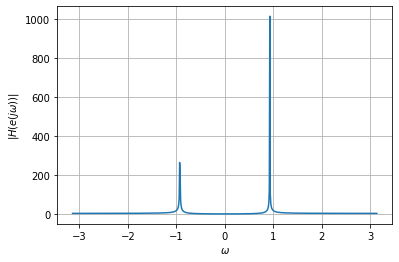

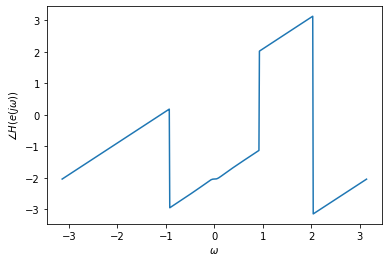

In [80]:
if __name__=="__main__":
    plotHejw(1+2j, 1, [0.9, 1.1], [0.6+0.8j, 0.6-0.8j])